In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

NUM_WORKERS = os.cpu_count()


def create_dataloaders(
    image_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int = NUM_WORKERS,
):
    # Use ImageFolder to create dataset(s)
    dataset = datasets.ImageFolder(image_dir, transform=transform)

    # Get class names
    class_names = dataset.classes

    train_data, test_data = torch.utils.data.random_split(dataset, [0.8, 0.2])

    # Turn images into data loaders
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_dataloader, test_dataloader, class_names

In [4]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

Remember, if you're going to use a pretrained model, it's generally important to ensure your own custom data is transformed/formatted in the same way the data the original model was trained on.

In [5]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [6]:
# Set the batch size
BATCH_SIZE = 32

# Setup directory paths to train and test images
image_dir = "data/train"

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    image_dir=image_dir,
    transform=pretrained_vit_transforms,
    batch_size=BATCH_SIZE,
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fdd79474610>,
 ['000', '001', '002', '003', '004', '005', '006', '007', '008', '009'])

In [7]:

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(
    device
)
pretrained_vit # uncomment for model output

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [8]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(
    model=pretrained_vit,
    input_size=(32, 3, 224, 224),  # (batch_size, color_channels, height, width)
    # col_names=["input_size"], # uncomment for smaller output
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 10]             768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [9]:
!pip install -q jupyter ipywidgets

In [10]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(
    model=pretrained_vit,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device,
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.8291 | train_acc: 0.4505 | test_loss: 1.2326 | test_acc: 0.8486
Epoch: 2 | train_loss: 0.9490 | train_acc: 0.8229 | test_loss: 0.6710 | test_acc: 0.8990
Epoch: 3 | train_loss: 0.5460 | train_acc: 0.9427 | test_loss: 0.4403 | test_acc: 0.9651
Epoch: 4 | train_loss: 0.3608 | train_acc: 0.9609 | test_loss: 0.3445 | test_acc: 0.9651
Epoch: 5 | train_loss: 0.2782 | train_acc: 0.9544 | test_loss: 0.2869 | test_acc: 0.9651
Epoch: 6 | train_loss: 0.2155 | train_acc: 0.9609 | test_loss: 0.2511 | test_acc: 0.9651
Epoch: 7 | train_loss: 0.1877 | train_acc: 0.9609 | test_loss: 0.2307 | test_acc: 0.9651
Epoch: 8 | train_loss: 0.1623 | train_acc: 0.9648 | test_loss: 0.2177 | test_acc: 0.9651
Epoch: 9 | train_loss: 0.1485 | train_acc: 0.9727 | test_loss: 0.2084 | test_acc: 0.9651
Epoch: 10 | train_loss: 0.1286 | train_acc: 0.9727 | test_loss: 0.1954 | test_acc: 0.9651


pretrained ViT performed far better than our custom ViT model trained from scratch (in the same amount of time).


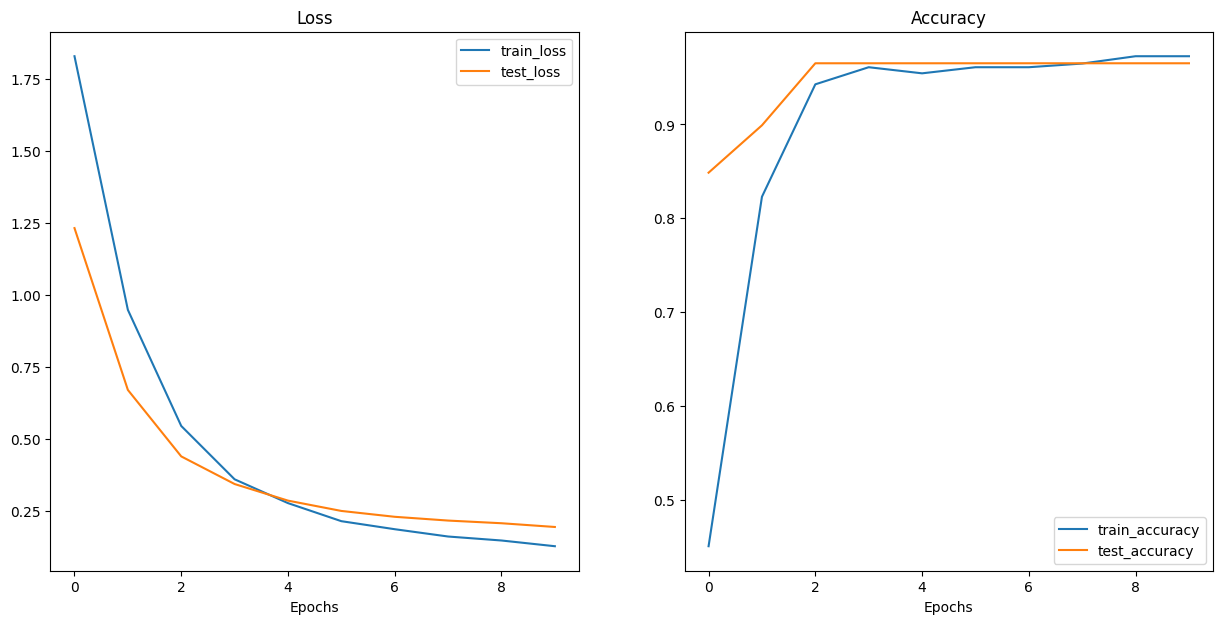

In [11]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

## That's the power of transfer learning!

We managed to get outstanding results with the same model architecture, except our custom implementation was trained from scratch (worse performance) and this feature extractor model has the power of pretrained weights from ImageNet behind it.

# Let's make Prediction:

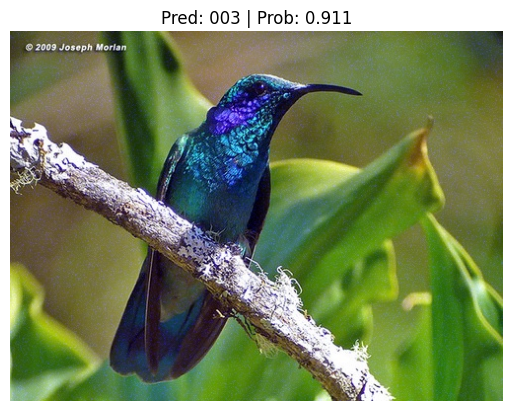

In [12]:
# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "test_img.jpg"

# Predict on custom image
pred_and_plot_image(
    model=pretrained_vit, image_path=custom_image_path, class_names=class_names
)

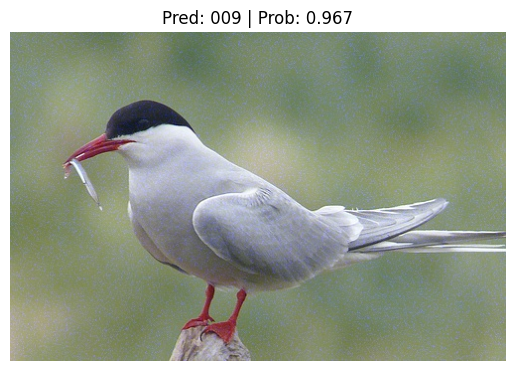

In [13]:
# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "test_1.jpg"

# Predict on custom image
pred_and_plot_image(
    model=pretrained_vit, image_path=custom_image_path, class_names=class_names
)